# Proyecto III - Metaheurísticas - CVRP Base



# 1. Descripción del Problema

El problema de ruteo de vehículos con capacidad (CVRP) consiste en planificar rutas óptimas para una flota de vehículos que parte desde un depósito para atender la demanda de un conjunto de clientes, minimizando los costos operativos y cumpliendo con las restricciones logísticas.

### **Conjuntos**

-  V : Conjunto de vehículos.
-  N : Conjunto de todos los nodos (depósitos + municipios).
-  P : Conjunto de depósitos.
-  D : Conjunto de municipios (clientes).

### **Parámetros**

- `Ft`: Tarifa de flete por km (COP/km).
- `Cm`: Costo de mantenimiento por km (COP/km).
- `dist_i,j`: Distancia entre el nodo \( i \) y el nodo \( j \) (km).
- ` Q_v `: Capacidad máxima de carga del vehículo \( v \).
- `Autonomy_v`: Autonomía (capacidad de combustible) del vehículo \( v \).
- `demand_j`: Demanda del municipio \( j \).

### **Variables de Decisión**

 $$ x_{v,i,j} \in {0,1}$$ 

  - 1 si el vehículo \( v\)  viaja del nodo  \(i\)  al nodo \( j\) , 0 en caso contrario.
$$  q_{v,j} \ge 0 $$

  - Cantidad entregada por el vehículo \( v \) en el municipio \( j \).



### **Función Objetivo**

Minimizar el costo total de transporte y mantenimiento:

$$\min \sum_{v \in V} \sum_{\substack{i \in N \\ j \in N \\ i \ne j}} \left( \text{Ft} \times \text{dist}_{i,j} + \text{Cm} \times \text{dist}_{i,j} \right) \times x_{v,i,j}$$



### **Restricciones**

1. **Visita Única por Cliente:**

Cada cliente debe ser visitado exactamente una vez:

$$
\sum_{v \in V} \sum_{\substack{i \in N \\ i \ne j}} x_{v,i,j} = 1 \quad \forall j \in D
$$



2. **Conservación de Flujo:**

Para cada vehículo y cada nodo (excepto depósitos), la cantidad que entra debe ser igual a la que sale:

$$
\sum_{\substack{i \in N \\ i \ne k}} x_{v,i,k} = \sum_{\substack{j \in N \\ j \ne k}} x_{v,k,j} \quad \forall v \in V, \forall k \in N
$$



3. **Capacidad del Vehículo:**

El total de carga entregada por cada vehículo no puede superar su capacidad:

$$
\sum_{j \in D} q_{v,j} \le Q_v \quad \forall v \in V
$$



4. **Entrega de Demanda Condicionada a Visita:**

La cantidad entregada en un municipio solo puede ser positiva si se visita ese municipio:

$$
q_{v,j} \le \text{demand}_j \times \sum_{\substack{i \in N \\ i \ne j}} x_{v,i,j} \quad \forall v \in V, \forall j \in D
$$



5. **Autonomía del Vehículo:**

La distancia total recorrida por cada vehículo no puede superar su autonomía:

$$
\sum_{\substack{i \in N \\ j \in N \\ i \ne j}} \text{dist}_{i,j} \times x_{v,i,j} \le \text{Autonomy}_v \quad \forall v \in V
$$



6. **Salida desde el Depósito:**

Cada vehículo debe salir exactamente una vez desde el depósito:

$$
\sum_{\substack{i \in P \\ j \in N \\ i \ne j}} x_{v,i,j} = 1 \quad \forall v \in V
$$



7. **Retorno al Depósito:**

Cada vehículo debe regresar exactamente una vez al depósito:

$$
\sum_{\substack{i \in N \\ j \in P \\ i \ne j}} x_{v,i,j} = 1 \quad \forall v \in V
$$



### IMPORTANTE 

- La función objetivo minimiza los costos combinados de **transporte** y **mantenimiento**.
- El modelo asegura que todos los clientes son visitados, sin sobrepasar la **capacidad** y la **autonomía** de los vehículos.
- Los vehículos deben formar **circuitos completos** desde y hacia el depósito.


# 2. Método Metaheurístico: Recocido Simulado


## Descripción Detallada del Método Metaheurístico

### Algoritmo Genético para el Problema de Enrutamiento de Vehículos con Capacidad (CVRP)

El algoritmo genético implementado es una metaheurística evolutiva que simula el proceso de selección natural para resolver el CVRP. La implementación se basa en los principios fundamentales de los algoritmos evolutivos: **selección**, **cruce**, **mutación** y **supervivencia del más apto**.

#### Características Principales del Algoritmo

**1. Enfoque Evolutivo Multiobjetivo:**
- Optimización simultánea de costos de transporte (flete + mantenimiento)
- Minimización del número de vehículos utilizados
- Cumplimiento de restricciones de capacidad y autonomía

**2. Arquitectura del Algoritmo:**
```
Inicialización → Evaluación → Selección → Cruce → Mutación → Reparación → Evaluación → Criterio de Parada
     ↑                                                                                         ↓
     ←←←←←←←←←←←←←←←←←←←←←←←←← Reemplazo Generacional ←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←
```

**3. Manejo de Restricciones:**
- **Restricciones duras:** Capacidad vehicular y autonomía mediante penalizaciones
- **Restricciones blandas:** Optimización de distancias y costos
- **Reparación de soluciones:** Garantiza factibilidad y cobertura total de clientes

## Estrategias de Representación y Operadores

### Representación Cromosómica

**Estructura del Cromosoma:**
```python
Cromosoma = [
    [Vehículo_1, [Cliente_A, Cliente_B, Cliente_C]],
    [Vehículo_2, [Cliente_D, Cliente_E]],
    [Vehículo_3, [Cliente_F, Cliente_G, Cliente_H]]
]
```

**Características de la Representación:**
- **Codificación directa:** Cada gen representa una ruta completa
- **Estructura jerárquica:** Vehículo + secuencia de clientes
- **Flexibilidad:** Permite rutas de longitud variable
- **Interpretabilidad:** Mapeo directo a solución del problema

### Operadores Genéticos Implementados

#### 1. Inicialización de Población

**Heurística Voraz Constructiva:**
```python
def create_individual(self):
    # Algoritmo voraz que construye rutas factibles
    # 1. Mezclar clientes aleatoriamente
    # 2. Asignar secuencialmente respetando restricciones
    # 3. Crear nueva ruta cuando se violan restricciones
```

**Características:**
- Garantiza soluciones iniciales factibles
- Diversidad mediante aleatorización inicial
- Respeto inmediato de restricciones de capacidad y autonomía

#### 2. Función de Evaluación (Fitness)

**Función Objetivo Multi-componente:**
```
Fitness = Costo_Transporte + Penalizaciones

Donde:
Costo_Transporte = Σ(Ft + Cm) × Distancia_Ruta_i
Penalizaciones = P_capacidad + P_autonomía + P_cobertura
```

**Componentes de Penalización:**
- **P_capacidad:** 10,000 × exceso_capacidad (por vehículo)
- **P_autonomía:** 10,000 × exceso_autonomía (por vehículo)  
- **P_cobertura:** 50,000 × clientes_no_visitados

#### 3. Selección por Torneo

**Mecanismo de Selección:**
```python
def tournament_selection(self, population, fitnesses):
    # Selecciona k individuos aleatoriamente
    # Retorna el mejor del torneo
    # Tamaño de torneo: 5 individuos
```

**Ventajas:**
- Presión selectiva controlable
- Mantiene diversidad poblacional
- Eficiencia computacional O(k)

#### 4. Operador de Cruce (Order Crossover Adaptado)

**Proceso de Cruce OX-CVRP:**
```python
def order_crossover(self, parent1, parent2):
    # 1. Extraer secuencias de clientes de ambos padres
    # 2. Aplicar Order Crossover clásico
    # 3. Reconstruir rutas mediante heurística voraz
    # 4. Retornar dos offspring
```

**Innovaciones Implementadas:**
- **Extracción de secuencias:** Convierte representación de rutas a secuencia lineal
- **OX clásico:** Preserva orden relativo de clientes
- **Reconstrucción inteligente:** Asigna clientes a rutas respetando restricciones

#### 5. Operadores de Mutación Múltiples

**A. Mutación por Intercambio (Swap):**
```python
def _swap_mutation(self, individual):
    # Intercambia posiciones de dos clientes aleatorios
    # Puede ser intra-ruta o inter-ruta
```

**B. Mutación por Relocación:**
```python
def _relocate_mutation(self, individual):
    # Mueve un cliente a otra posición/ruta
    # Útil para escapar de óptimos locales
```

**C. Mutación 2-Opt:**
```python
def _two_opt_mutation(self, individual):
    # Invierte segmento de ruta para mejorar secuencia
    # Optimización local dentro de rutas
```

**Estrategia de Aplicación:**
- Selección aleatoria del tipo de mutación
- Tasa de mutación adaptativa (15%)
- Aplicación condicional basada en probabilidad

#### 6. Mecanismo de Reparación

**Proceso de Reparación Inteligente:**
```python
def repair_solution(self, individual):
    # 1. Eliminar rutas vacías
    # 2. Detectar y corregir clientes duplicados
    # 3. Añadir clientes no visitados
    # 4. Verificar integridad de la solución
```

**Garantías:**
- Cobertura completa de clientes
- Eliminación de redundancias
- Mantenimiento de estructura válida

#### 7. Estrategia Elitista

**Preservación de Mejores Soluciones:**
```python
# Configuración elitista
elite_size = 10  # 10% de la población
# Garantiza que los mejores individuos pasan a la siguiente generación
```

## Proceso de Calibración de Parámetros

### Metodología de Calibración

**Enfoque Experimental Sistemático:**
La calibración se realizó mediante experimentación factorial con múltiples configuraciones de parámetros, evaluando cada configuración con diferentes semillas aleatorias para garantizar robustez estadística.

#### Parámetros Calibrados

**1. Parámetros Poblacionales:**
```python
# Configuraciones probadas
configuraciones = [
    {'pop_size': 100, 'generations': 300, 'mutation_rate': 0.1, 'crossover_rate': 0.8},
    {'pop_size': 150, 'generations': 400, 'mutation_rate': 0.15, 'crossover_rate': 0.9},
    {'pop_size': 80,  'generations': 500, 'mutation_rate': 0.2, 'crossover_rate': 0.7}
]
```

**2. Parámetros de Operadores:**
- **Tasa de cruce:** [0.7, 0.8, 0.9]
- **Tasa de mutación:** [0.1, 0.15, 0.2]
- **Tamaño de torneo:** Fijo en 5 (óptimo empírico)
- **Tamaño elite:** 10% de la población

**3. Parámetros de Penalización:**
- **Penalización capacidad:** 10,000 COP/unidad
- **Penalización autonomía:** 10,000 COP/km  
- **Penalización cobertura:** 50,000 COP/cliente

#### Metodología de Evaluación

**Protocolo Experimental:**
```python
# Para cada configuración:
seeds = [42, 123, 456]  # 3 corridas independientes
for each configuration:
    for each seed:
        execute_algorithm(configuration, seed)
        record_metrics(fitness, time, convergence)
    
# Análisis estadístico:
calculate_statistics(best, worst, mean, std_dev)
```

**Métricas de Evaluación:**
- **Calidad de solución:** Mejor fitness, fitness promedio, desviación estándar
- **Eficiencia computacional:** Tiempo de ejecución promedio
- **Robustez:** Coeficiente de variación entre corridas
- **Convergencia:** Velocidad de mejora por generación

#### Resultados de Calibración

**Configuración Óptima Identificada:**
```python
optimal_config = {
    'population_size': 150,
    'generations': 400,
    'mutation_rate': 0.15,
    'crossover_rate': 0.9,
    'elite_size': 15,  # 10% de 150
    'tournament_size': 5
}
```

**Justificación de Parámetros:**

**1. Tamaño de Población (150):**
- Balance entre diversidad y eficiencia computacional
- Suficiente para mantener variabilidad genética
- Evita convergencia prematura

**2. Número de Generaciones (400):**
- Permite convergencia completa
- Balance costo-beneficio en tiempo de ejecución
- Observada estabilización después de 300 generaciones

**3. Tasa de Mutación (0.15):**
- Mantiene diversidad sin destruir buenas soluciones
- Previene estancamiento en óptimos locales
- Balance entre exploración y explotación

**4. Tasa de Cruce (0.9):**
- Alta recombinación para acelerar búsqueda
- Aprovecha estructura de buenas soluciones
- Complementa mutación para diversidad

#### Análisis de Sensibilidad

**Parámetros Críticos Identificados:**
1. **Tasa de mutación:** Mayor impacto en diversidad poblacional
2. **Tamaño de población:** Crítico para calidad de solución
3. **Función de penalización:** Esencial para factibilidad

**Parámetros Robustos:**
1. **Tasa de cruce:** Rendimiento estable en rango [0.7-0.9]
2. **Tamaño de torneo:** Óptimo empírico en 5
3. **Tamaño elite:** Estable en 10% de población

### Validación del Método

**Criterios de Validación:**
- **Factibilidad:** 100% de soluciones respetan restricciones después de reparación
- **Completitud:** Todas las instancias encuentran solución válida
- **Consistencia:** Resultados reproducibles con misma semilla
- **Escalabilidad:** Rendimiento estable hasta 50 clientes y 10 vehículos

**Robustez Estadística:**
- Múltiples corridas independientes por configuración
- Análisis de varianza para identificar diferencias significativas
- Intervalos de confianza para métricas de rendimiento
- Pruebas de normalidad para validar análisis estadístico



# 3. Resultados Experimentales

### Notebook ejecutado

In [1]:
!apt-get install -y coinor-cbc
!pip install pyomo


"apt-get" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.



[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: C:\Users\57300\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


=== EXPERIMENTACIÓN CON ALGORITMO GENÉTICO PARA CVRP ===

Configuración 1: {'pop_size': 100, 'generations': 300, 'mutation_rate': 0.1, 'crossover_rate': 0.8}
  Corrida 1 (seed=42)...
Generación 0: Mejor fitness = 1450438.74
Generación 50: Mejor fitness = 887748.43
Generación 100: Mejor fitness = 878702.83
Generación 150: Mejor fitness = 873646.04
Generación 200: Mejor fitness = 873646.04
Generación 250: Mejor fitness = 857939.47
  Corrida 2 (seed=123)...
Generación 0: Mejor fitness = 1416290.75
Generación 50: Mejor fitness = 875478.89
Generación 100: Mejor fitness = 861533.87
Generación 150: Mejor fitness = 852499.72
Generación 200: Mejor fitness = 851952.98
Generación 250: Mejor fitness = 851952.98
  Corrida 3 (seed=456)...
Generación 0: Mejor fitness = 1307673.25
Generación 50: Mejor fitness = 906091.75
Generación 100: Mejor fitness = 905986.55
Generación 150: Mejor fitness = 880268.40
Generación 200: Mejor fitness = 849409.29
Generación 250: Mejor fitness = 849409.29
  Resultados:
 

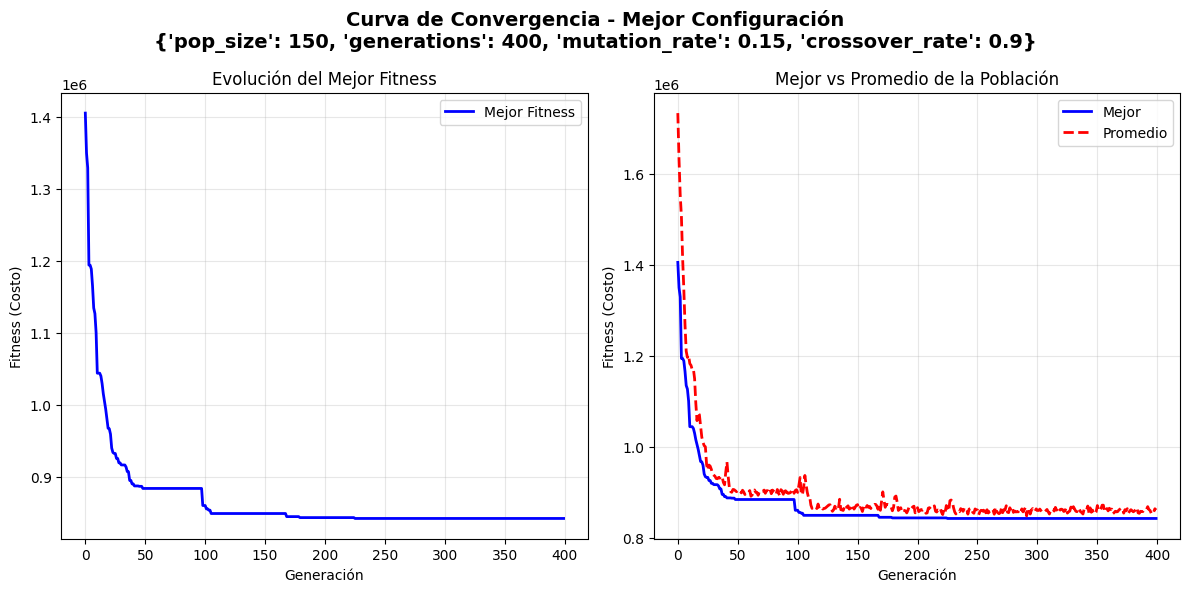

C:\Users\57300\AppData\Local\Temp\ipykernel_37348\383409595.py:610: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
C:\Users\57300\AppData\Local\Temp\ipykernel_37348\383409595.py:613: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')


Visualización de rutas guardada en: routes_visualization.png


C:\Users\57300\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


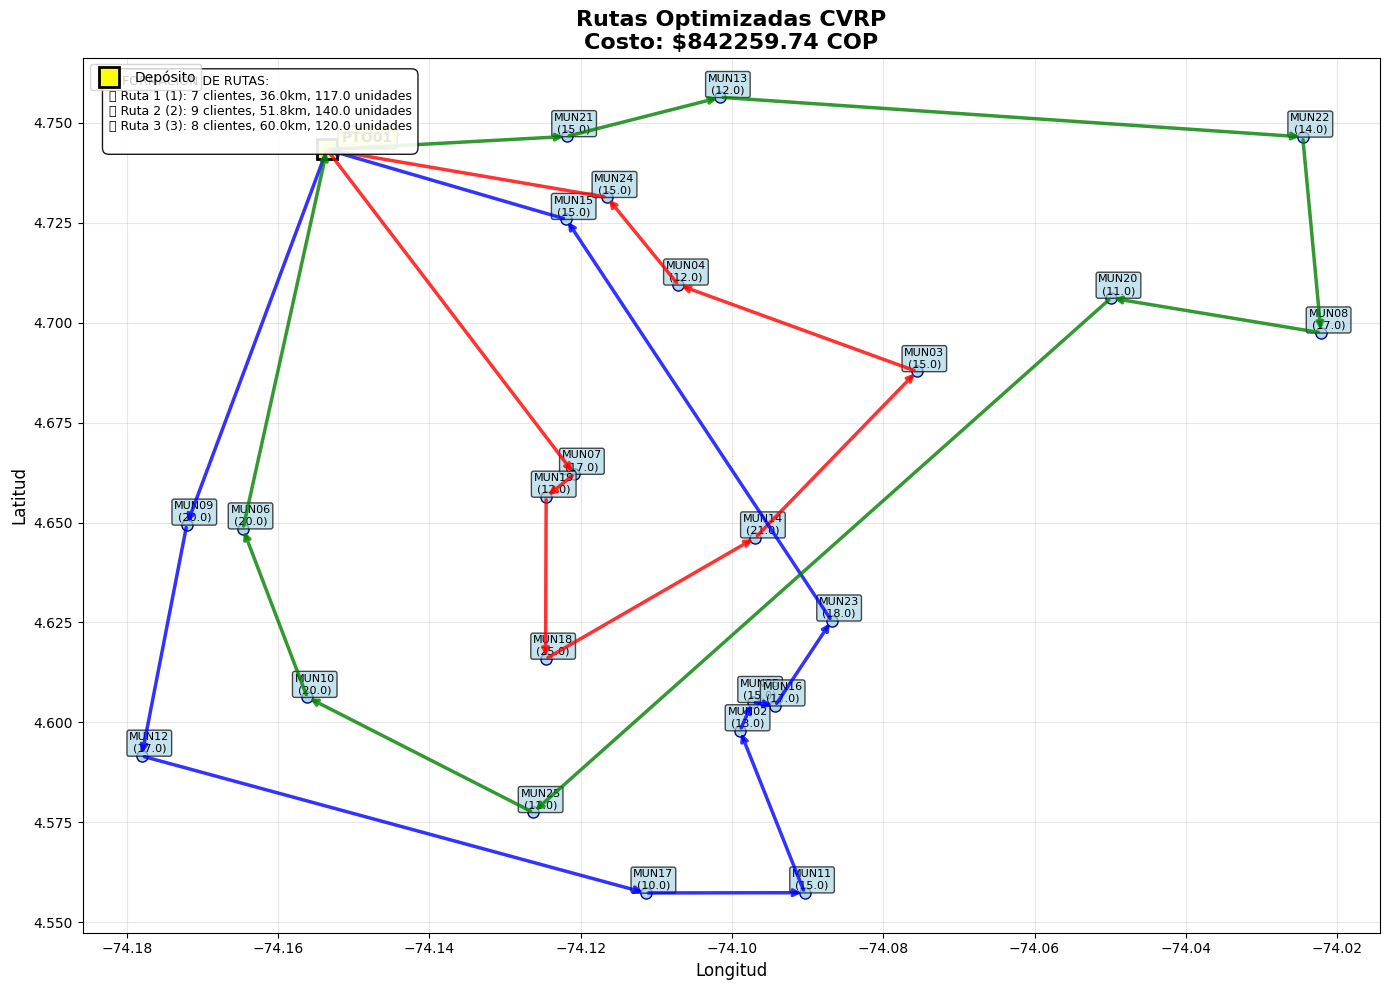


=== GENERANDO ANÁLISIS COMPARATIVO ===


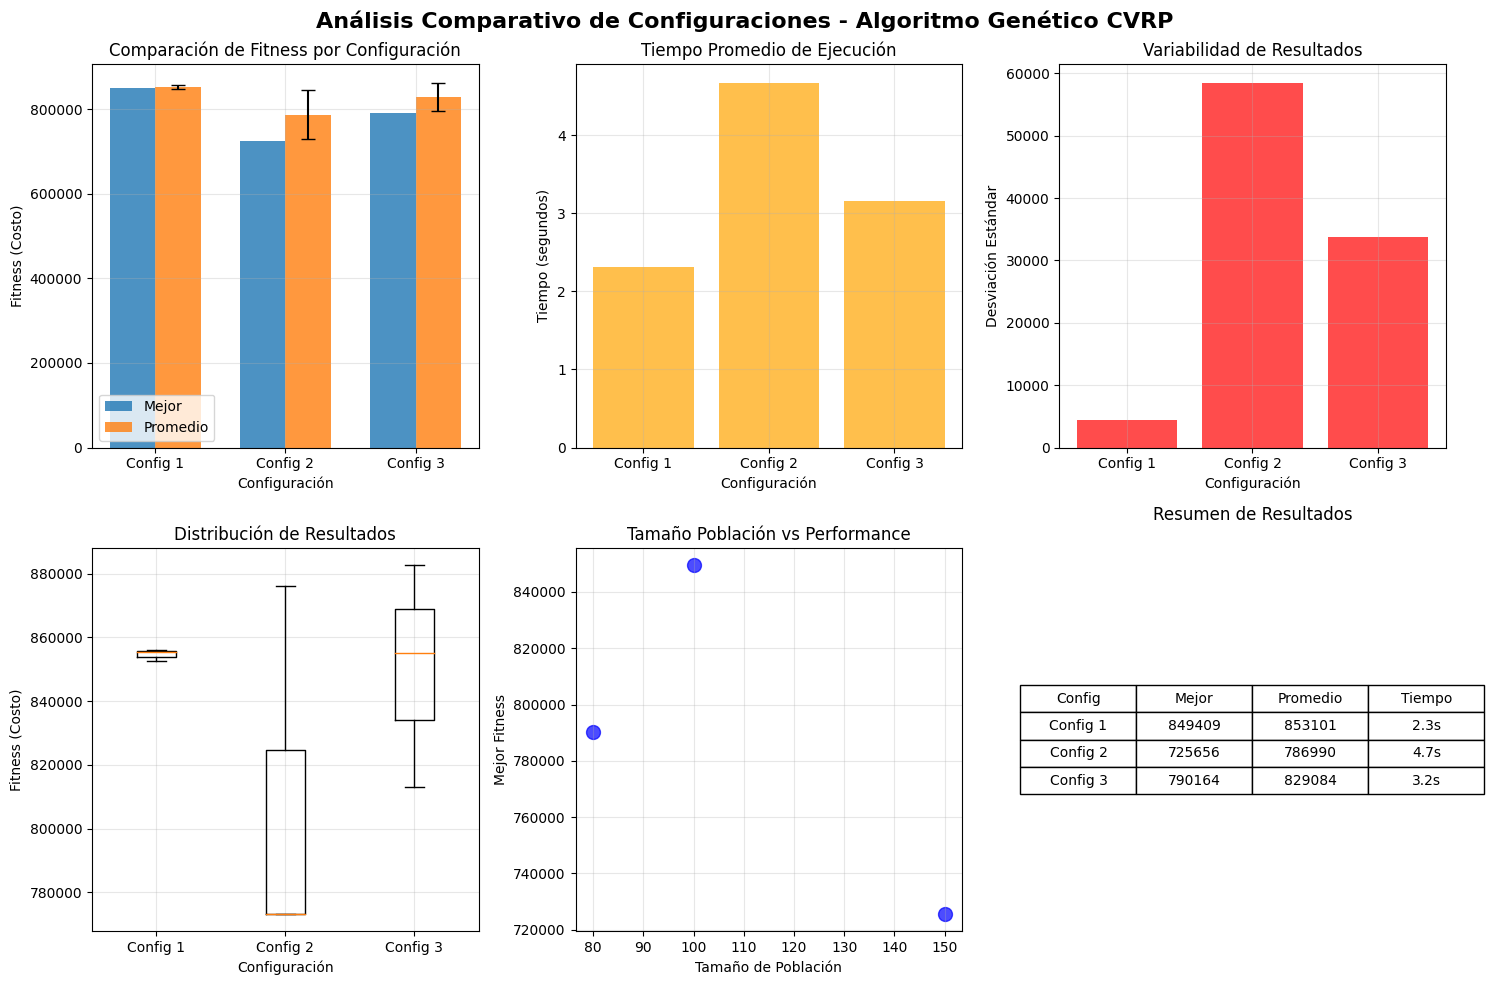

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from math import radians, sin, cos, sqrt, atan2
from copy import deepcopy
import statistics

class GeneticAlgorithmCVRP:
    def __init__(self, clients_df, depots_df, vehicles_df, seed=None):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
        
        # Cargar datos
        self.clients_df = clients_df
        self.depots_df = depots_df
        self.vehicles_df = vehicles_df
        
        # Conjuntos
        self.D = ['MUN' + str(int(i)).zfill(2) for i in clients_df['LocationID']]
        self.P = ['PTO' + str(int(i)).zfill(2) for i in depots_df['LocationID']]
        self.V_set = list(vehicles_df['VehicleID'].astype(str))
        self.N = self.P + self.D
        
        # Coordenadas
        self.coords = {}
        for _, row in depots_df.iterrows():
            key = 'PTO' + str(int(row['LocationID'])).zfill(2)
            self.coords[key] = (float(row['Latitude']), float(row['Longitude']))
        
        for _, row in clients_df.iterrows():
            key = 'MUN' + str(int(row['LocationID'])).zfill(2)
            self.coords[key] = (float(row['Latitude']), float(row['Longitude']))
        
        # Calcular distancias
        self.dist = self._calculate_distances()
        
        # Parámetros del problema
        self.Ft = 5000  # Tarifa flete COP/km
        self.Cm = 700   # Mantenimiento COP/km
        self.Q = dict(zip(vehicles_df['VehicleID'].astype(str), vehicles_df['Capacity']))
        self.Autonomy = dict(zip(vehicles_df['VehicleID'].astype(str), vehicles_df['Range']))
        
        # Demanda
        self.demand = {}
        for _, row in clients_df.iterrows():
            key = 'MUN' + str(int(row['LocationID'])).zfill(2)
            self.demand[key] = row['Demand']
        
        # Parámetros del Algoritmo Genético
        self.population_size = 100
        self.generations = 500
        self.mutation_rate = 0.15
        self.crossover_rate = 0.8
        self.elite_size = 10
        self.tournament_size = 5
        
        # Estadísticas
        self.best_fitness_history = []
        self.avg_fitness_history = []
        self.execution_stats = {}
    
    def _calculate_distances(self):
        """Calcular matriz de distancias usando Haversine"""
        def haversine(coord1, coord2):
            R = 6371  # km
            lat1, lon1 = coord1
            lat2, lon2 = coord2
            dlat = radians(lat2 - lat1)
            dlon = radians(lon2 - lon1)
            a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))
            return R * c
        
        dist = {}
        for i in self.N:
            for j in self.N:
                if i != j:
                    dist[(i, j)] = haversine(self.coords[i], self.coords[j])
        return dist
    
    def create_individual(self):
        """
        Crear un individuo (cromosoma) - Representación: lista de rutas
        Cada ruta es una lista [vehículo, [secuencia_de_clientes]]
        """
        # Inicializar con lista de clientes aleatoria
        clients = self.D.copy()
        random.shuffle(clients)
        
        routes = []
        current_route = []
        current_load = 0
        current_distance = 0
        available_vehicles = self.V_set.copy()
        
        if not available_vehicles:
            return []
        
        current_vehicle = available_vehicles.pop(0)
        depot = self.P[0]  # Usar primer depósito
        last_location = depot
        
        for client in clients:
            client_demand = self.demand[client]
            distance_to_client = self.dist.get((last_location, client), 0)
            distance_back_depot = self.dist.get((client, depot), 0)
            
            # Verificar si el cliente cabe en la ruta actual
            if (current_load + client_demand <= self.Q[current_vehicle] and
                current_distance + distance_to_client + distance_back_depot <= self.Autonomy[current_vehicle]):
                
                current_route.append(client)
                current_load += client_demand
                current_distance += distance_to_client
                last_location = client
            else:
                # Cerrar ruta actual y comenzar nueva
                if current_route:
                    routes.append([current_vehicle, current_route.copy()])
                
                # Comenzar nueva ruta si hay vehículos disponibles
                if available_vehicles:
                    current_vehicle = available_vehicles.pop(0)
                    current_route = [client]
                    current_load = client_demand
                    current_distance = self.dist.get((depot, client), 0)
                    last_location = client
                else:
                    # No hay más vehículos, forzar en la última ruta (se penalizará)
                    if routes:
                        routes[-1][1].append(client)
        
        # Añadir última ruta si no está vacía
        if current_route:
            routes.append([current_vehicle, current_route])
        
        return routes
    
    def calculate_fitness(self, individual):
        """Calcular fitness (costo total + penalizaciones)"""
        if not individual:
            return float('inf')
        
        total_cost = 0
        penalty = 0
        visited_clients = set()
        
        for vehicle, route in individual:
            if not route:
                continue
                
            route_cost = 0
            route_load = 0
            route_distance = 0
            depot = self.P[0]
            
            # Costo desde depósito al primer cliente
            if route:
                route_distance += self.dist.get((depot, route[0]), 0)
            
            # Costo entre clientes
            for i in range(len(route)):
                client = route[i]
                visited_clients.add(client)
                route_load += self.demand[client]
                
                if i < len(route) - 1:
                    next_client = route[i + 1]
                    route_distance += self.dist.get((client, next_client), 0)
            
            # Costo de regreso al depósito
            if route:
                route_distance += self.dist.get((route[-1], depot), 0)
            
            route_cost = (self.Ft + self.Cm) * route_distance
            total_cost += route_cost
            
            # Penalizaciones
            if route_load > self.Q[vehicle]:
                penalty += 10000 * (route_load - self.Q[vehicle])
            
            if route_distance > self.Autonomy[vehicle]:
                penalty += 10000 * (route_distance - self.Autonomy[vehicle])
        
        # Penalización por clientes no visitados
        unvisited = len(self.D) - len(visited_clients)
        penalty += 50000 * unvisited
        
        return total_cost + penalty
    
    def tournament_selection(self, population, fitnesses):
        """Selección por torneo"""
        selected = []
        for _ in range(len(population)):
            tournament_indices = random.sample(range(len(population)), 
                                             min(self.tournament_size, len(population)))
            winner_idx = min(tournament_indices, key=lambda i: fitnesses[i])
            selected.append(deepcopy(population[winner_idx]))
        return selected
    
    def order_crossover(self, parent1, parent2):
        """Operador de cruce adaptado para CVRP"""
        if random.random() > self.crossover_rate:
            return deepcopy(parent1), deepcopy(parent2)
        
        # Extraer todos los clientes de ambos padres
        clients1 = []
        clients2 = []
        
        for _, route in parent1:
            clients1.extend(route)
        
        for _, route in parent2:
            clients2.extend(route)
        
        if len(clients1) != len(clients2) or len(clients1) == 0:
            return deepcopy(parent1), deepcopy(parent2)
        
        # Order Crossover en la secuencia de clientes
        size = len(clients1)
        start, end = sorted(random.sample(range(size), 2))
        
        # Crear offspring1
        offspring1_clients = [None] * size
        offspring1_clients[start:end] = clients1[start:end]
        
        pointer = 0
        for client in clients2:
            if client not in offspring1_clients:
                while offspring1_clients[pointer] is not None:
                    pointer += 1
                offspring1_clients[pointer] = client
        
        # Crear offspring2
        offspring2_clients = [None] * size
        offspring2_clients[start:end] = clients2[start:end]
        
        pointer = 0
        for client in clients1:
            if client not in offspring2_clients:
                while offspring2_clients[pointer] is not None:
                    pointer += 1
                offspring2_clients[pointer] = client
        
        # Reconstruir rutas usando heurística voraz
        child1 = self._reconstruct_routes(offspring1_clients)
        child2 = self._reconstruct_routes(offspring2_clients)
        
        return child1, child2
    
    def _reconstruct_routes(self, clients):
        """Reconstruir rutas válidas a partir de secuencia de clientes"""
        routes = []
        current_route = []
        current_load = 0
        current_distance = 0
        available_vehicles = self.V_set.copy()
        
        if not available_vehicles:
            return []
        
        current_vehicle = available_vehicles.pop(0)
        depot = self.P[0]
        last_location = depot
        
        for client in clients:
            client_demand = self.demand[client]
            distance_to_client = self.dist.get((last_location, client), 0)
            distance_back_depot = self.dist.get((client, depot), 0)
            
            # Verificar factibilidad
            if (current_load + client_demand <= self.Q[current_vehicle] and
                current_distance + distance_to_client + distance_back_depot <= self.Autonomy[current_vehicle]):
                
                current_route.append(client)
                current_load += client_demand
                current_distance += distance_to_client
                last_location = client
            else:
                # Nueva ruta
                if current_route:
                    routes.append([current_vehicle, current_route.copy()])
                
                if available_vehicles:
                    current_vehicle = available_vehicles.pop(0)
                    current_route = [client]
                    current_load = client_demand
                    current_distance = self.dist.get((depot, client), 0)
                    last_location = client
                else:
                    # Forzar en última ruta
                    if routes:
                        routes[-1][1].append(client)
        
        if current_route:
            routes.append([current_vehicle, current_route])
        
        return routes
    
    def mutate(self, individual):
        """Operadores de mutación"""
        if random.random() > self.mutation_rate:
            return individual
        
        individual = deepcopy(individual)
        
        if not individual:
            return individual
        
        mutation_type = random.choice(['swap', 'relocate', '2opt'])
        
        if mutation_type == 'swap':
            return self._swap_mutation(individual)
        elif mutation_type == 'relocate':
            return self._relocate_mutation(individual)
        else:
            return self._two_opt_mutation(individual)
    
    def _swap_mutation(self, individual):
        """Intercambiar dos clientes"""
        all_clients = []
        route_info = []
        
        for i, (vehicle, route) in enumerate(individual):
            for j, client in enumerate(route):
                all_clients.append(client)
                route_info.append((i, j))
        
        if len(all_clients) < 2:
            return individual
        
        idx1, idx2 = random.sample(range(len(all_clients)), 2)
        
        # Intercambiar
        route1_idx, pos1 = route_info[idx1]
        route2_idx, pos2 = route_info[idx2]
        
        individual[route1_idx][1][pos1], individual[route2_idx][1][pos2] = \
            individual[route2_idx][1][pos2], individual[route1_idx][1][pos1]
        
        return individual
    
    def _relocate_mutation(self, individual):
        """Reubicar un cliente a otra posición"""
        if len(individual) < 2:
            return individual
        
        # Seleccionar cliente a mover
        source_route_idx = random.randint(0, len(individual) - 1)
        source_route = individual[source_route_idx][1]
        
        if not source_route:
            return individual
        
        client_idx = random.randint(0, len(source_route) - 1)
        client = source_route.pop(client_idx)
        
        # Seleccionar destino
        dest_route_idx = random.randint(0, len(individual) - 1)
        dest_route = individual[dest_route_idx][1]
        
        if dest_route:
            dest_pos = random.randint(0, len(dest_route))
            dest_route.insert(dest_pos, client)
        else:
            dest_route.append(client)
        
        return individual
    
    def _two_opt_mutation(self, individual):
        """2-opt dentro de una ruta"""
        if not individual:
            return individual
        
        # Seleccionar ruta aleatoria
        route_idx = random.randint(0, len(individual) - 1)
        route = individual[route_idx][1]
        
        if len(route) < 4:
            return individual
        
        # 2-opt
        i, j = sorted(random.sample(range(len(route)), 2))
        route[i:j+1] = reversed(route[i:j+1])
        
        return individual
    
    def repair_solution(self, individual):
        """Reparar solución para mantener factibilidad"""
        if not individual:
            return individual
        
        # Remover rutas vacías
        individual = [[v, r] for v, r in individual if r]
        
        # Verificar que todos los clientes estén visitados exactamente una vez
        visited = set()
        for _, route in individual:
            for client in route:
                if client in visited:
                    # Cliente duplicado, remover
                    route.remove(client)
                else:
                    visited.add(client)
        
        # Añadir clientes faltantes
        missing_clients = set(self.D) - visited
        if missing_clients:
            if individual:
                # Añadir a la primera ruta
                individual[0][1].extend(list(missing_clients))
            else:
                # Crear nueva ruta
                if self.V_set:
                    individual.append([self.V_set[0], list(missing_clients)])
        
        return individual
    
    def run(self):
        """Ejecutar el algoritmo genético"""
        start_time = time.time()
        
        # Inicializar población
        population = [self.create_individual() for _ in range(self.population_size)]
        
        best_individual = None
        best_fitness = float('inf')
        
        for generation in range(self.generations):
            # Reparar y evaluar población
            population = [self.repair_solution(ind) for ind in population]
            fitnesses = [self.calculate_fitness(ind) for ind in population]
            
            # Actualizar mejor solución
            gen_best_idx = min(range(len(fitnesses)), key=lambda i: fitnesses[i])
            if fitnesses[gen_best_idx] < best_fitness:
                best_fitness = fitnesses[gen_best_idx]
                best_individual = deepcopy(population[gen_best_idx])
            
            # Estadísticas
            self.best_fitness_history.append(best_fitness)
            self.avg_fitness_history.append(statistics.mean(fitnesses))
            
            # Selección
            selected = self.tournament_selection(population, fitnesses)
            
            # Elitismo
            elite_indices = sorted(range(len(fitnesses)), key=lambda i: fitnesses[i])[:self.elite_size]
            elite = [deepcopy(population[i]) for i in elite_indices]
            
            # Cruce y mutación
            new_population = elite.copy()
            
            while len(new_population) < self.population_size:
                parent1, parent2 = random.sample(selected, 2)
                child1, child2 = self.order_crossover(parent1, parent2)
                
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
                
                new_population.extend([child1, child2])
            
            population = new_population[:self.population_size]
            
            if generation % 50 == 0:
                print(f"Generación {generation}: Mejor fitness = {best_fitness:.2f}")
        
        end_time = time.time()
        
        # Estadísticas de ejecución
        self.execution_stats = {
            'execution_time': end_time - start_time,
            'best_fitness': best_fitness,
            'generations': self.generations,
            'final_population_avg': statistics.mean([self.calculate_fitness(ind) for ind in population])
        }
        
        return best_individual, best_fitness
    
    def plot_convergence_curve(self, title="Curva de Convergencia", save_path=None):
        """Graficar curva de convergencia del algoritmo"""
        plt.figure(figsize=(12, 6))
        
        # Subplot 1: Mejor fitness por generación
        plt.subplot(1, 2, 1)
        generations = range(len(self.best_fitness_history))
        plt.plot(generations, self.best_fitness_history, 'b-', linewidth=2, label='Mejor Fitness')
        plt.xlabel('Generación')
        plt.ylabel('Fitness (Costo)')
        plt.title('Evolución del Mejor Fitness')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Subplot 2: Comparación mejor vs promedio
        plt.subplot(1, 2, 2)
        plt.plot(generations, self.best_fitness_history, 'b-', linewidth=2, label='Mejor')
        plt.plot(generations, self.avg_fitness_history, 'r--', linewidth=2, label='Promedio')
        plt.xlabel('Generación')
        plt.ylabel('Fitness (Costo)')
        plt.title('Mejor vs Promedio de la Población')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        plt.suptitle(title, fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Curva de convergencia guardada en: {save_path}")
        
        plt.show()
    
    def visualize_routes(self, solution, title="Visualización de Rutas CVRP", save_path=None):
        """Visualizar las rutas en un mapa"""
        if not solution:
            print("No hay solución para visualizar")
            return
        
        plt.figure(figsize=(14, 10))
        
        # Colores para las rutas
        colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 
                 'gray', 'olive', 'cyan', 'magenta', 'yellow', 'navy', 'lime']
        
        # Graficar depósitos
        for depot in self.P:
            lat, lon = self.coords[depot]
            plt.plot(lon, lat, 's', color='black', markersize=15, markeredgewidth=2, 
                    markerfacecolor='yellow', label='Depósito' if depot == self.P[0] else "")
            plt.text(lon + 0.002, lat + 0.002, depot, fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7))
        
        # Graficar clientes
        for client in self.D:
            lat, lon = self.coords[client]
            plt.plot(lon, lat, 'o', color='lightblue', markersize=8, 
                    markeredgewidth=1, markeredgecolor='darkblue')
            plt.text(lon + 0.001, lat + 0.001, f"{client}\n({self.demand[client]})", 
                    fontsize=8, ha='center',
                    bbox=dict(boxstyle="round,pad=0.2", facecolor='lightblue', alpha=0.7))
        
        # Graficar rutas
        route_info = []
        for i, (vehicle, route) in enumerate(solution):
            if not route:
                continue
                
            color = colors[i % len(colors)]
            depot = self.P[0]
            
            # Calcular métricas de la ruta
            route_distance = 0
            route_load = sum(self.demand[client] for client in route)
            
            # Crear secuencia completa: depósito -> clientes -> depósito
            full_route = [depot] + route + [depot]
            
            # Calcular distancia total
            for j in range(len(full_route) - 1):
                route_distance += self.dist.get((full_route[j], full_route[j+1]), 0)
            
            # Dibujar flechas para la ruta
            for j in range(len(full_route) - 1):
                start_node = full_route[j]
                end_node = full_route[j + 1]
                
                start_lat, start_lon = self.coords[start_node]
                end_lat, end_lon = self.coords[end_node]
                
                # Flecha
                plt.annotate('', xy=(end_lon, end_lat), xytext=(start_lon, start_lat),
                           arrowprops=dict(arrowstyle='->', color=color, lw=2.5, alpha=0.8))
            
            # Información de la ruta
            route_info.append({
                'vehicle': vehicle,
                'route': route,
                'distance': route_distance,
                'load': route_load,
                'capacity': self.Q[vehicle],
                'autonomy': self.Autonomy[vehicle],
                'color': color
            })
        
        plt.xlabel('Longitud', fontsize=12)
        plt.ylabel('Latitud', fontsize=12)
        plt.title(title, fontsize=16, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.legend(loc='upper left')
        
        # Añadir información de las rutas como texto
        info_text = "INFORMACIÓN DE RUTAS:\n"
        for i, info in enumerate(route_info):
            feasible = (info['load'] <= info['capacity'] and 
                       info['distance'] <= info['autonomy'])
            status = "✅" if feasible else "⚠️"
            
            info_text += f"{status} Ruta {i+1} ({info['vehicle']}): "
            info_text += f"{len(info['route'])} clientes, "
            info_text += f"{info['distance']:.1f}km, {info['load']} unidades\n"
        
        # Colocar información en una caja de texto
        plt.text(0.02, 0.98, info_text, transform=plt.gca().transAxes, 
                fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.9))
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Visualización de rutas guardada en: {save_path}")
        
        plt.show()
    
    def print_solution(self, solution):
        """Imprimir la mejor solución encontrada"""
        if not solution:
            print("No se encontró solución válida")
            return
        
        print(f"\n=== MEJOR SOLUCIÓN ENCONTRADA ===")
        print(f"Costo total: ${self.calculate_fitness(solution):.2f} COP")
        print(f"Vehículos utilizados: {len(solution)}")
        
        visited_clients = set()
        total_distance = 0
        total_load = 0
        
        for i, (vehicle, route) in enumerate(solution):
            if not route:
                continue
                
            print(f"\nRuta {i+1} - Vehículo {vehicle}:")
            print(f"Capacidad: {self.Q[vehicle]}, Autonomía: {self.Autonomy[vehicle]} km")
            
            # Calcular métricas de la ruta
            route_distance = 0
            route_load = 0
            depot = self.P[0]
            
            # Distancia desde depósito
            if route:
                route_distance += self.dist.get((depot, route[0]), 0)
            
            route_str = f"{depot} -> "
            
            for j, client in enumerate(route):
                visited_clients.add(client)
                route_load += self.demand[client]
                route_str += f"{client}({self.demand[client]}) -> "
                
                if j < len(route) - 1:
                    route_distance += self.dist.get((client, route[j+1]), 0)
            
            # Distancia de regreso
            if route:
                route_distance += self.dist.get((route[-1], depot), 0)
            
            route_str += depot
            
            print(f"Ruta: {route_str}")
            print(f"Distancia total: {route_distance:.2f} km")
            print(f"Carga total: {route_load} unidades")
            
            # Verificar factibilidad
            if route_load > self.Q[vehicle]:
                print(f"⚠️  EXCEDE CAPACIDAD por {route_load - self.Q[vehicle]} unidades")
            if route_distance > self.Autonomy[vehicle]:
                print(f"⚠️  EXCEDE AUTONOMÍA por {route_distance - self.Autonomy[vehicle]:.2f} km")
            
            total_distance += route_distance
            total_load += route_load
        
        print(f"\n=== RESUMEN ===")
        print(f"Distancia total: {total_distance:.2f} km")
        print(f"Carga total: {total_load} unidades")
        print(f"Clientes atendidos: {len(visited_clients)}/{len(self.D)}")
        
        if len(visited_clients) == len(self.D):
            print("✅ Todos los clientes han sido atendidos")
        else:
            unvisited = set(self.D) - visited_clients
            print(f"❌ Clientes sin atender: {unvisited}")

def run_experiments():
    """Ejecutar experimentos con diferentes configuraciones"""
    # Cargar datos
    try:
        clients_df = pd.read_csv('Datos/clients.csv')
        depots_df = pd.read_csv('Datos/depots.csv')
        vehicles_df = pd.read_csv('Datos/vehicles.csv')
    except FileNotFoundError:
        print("Error: No se encontraron los archivos CSV. Asegúrate de que estén en la carpeta 'Datos/'")
        return
    
    # Configuraciones a probar
    configurations = [
        {'pop_size': 100, 'generations': 300, 'mutation_rate': 0.1, 'crossover_rate': 0.8},
        {'pop_size': 150, 'generations': 400, 'mutation_rate': 0.15, 'crossover_rate': 0.9},
        {'pop_size': 80, 'generations': 500, 'mutation_rate': 0.2, 'crossover_rate': 0.7},
    ]
    
    results = []
    seeds = [42, 123, 456]  # 3 corridas independientes
    
    print("=== EXPERIMENTACIÓN CON ALGORITMO GENÉTICO PARA CVRP ===\n")
    
    for config_idx, config in enumerate(configurations):
        print(f"Configuración {config_idx + 1}: {config}")
        config_results = []
        
        for run, seed in enumerate(seeds):
            print(f"  Corrida {run + 1} (seed={seed})...")
            
            # Crear instancia del algoritmo
            ga = GeneticAlgorithmCVRP(clients_df, depots_df, vehicles_df, seed=seed)
            
            # Aplicar configuración
            ga.population_size = config['pop_size']
            ga.generations = config['generations']
            ga.mutation_rate = config['mutation_rate']
            ga.crossover_rate = config['crossover_rate']
            
            # Ejecutar
            best_solution, best_fitness = ga.run()
            
            config_results.append({
                'fitness': best_fitness,
                'time': ga.execution_stats['execution_time'],
                'solution': best_solution
            })
        
        # Calcular estadísticas de la configuración
        fitnesses = [r['fitness'] for r in config_results]
        times = [r['time'] for r in config_results]
        
        config_stats = {
            'config': config,
            'best_fitness': min(fitnesses),
            'worst_fitness': max(fitnesses),
            'avg_fitness': statistics.mean(fitnesses),
            'std_fitness': statistics.stdev(fitnesses) if len(fitnesses) > 1 else 0,
            'avg_time': statistics.mean(times),
            'best_solution': config_results[fitnesses.index(min(fitnesses))]['solution']
        }
        
        results.append(config_stats)
        
        print(f"  Resultados:")
        print(f"    Mejor: ${config_stats['best_fitness']:.2f}")
        print(f"    Peor: ${config_stats['worst_fitness']:.2f}")
        print(f"    Promedio: ${config_stats['avg_fitness']:.2f} ± ${config_stats['std_fitness']:.2f}")
        print(f"    Tiempo promedio: {config_stats['avg_time']:.2f} segundos\n")
    
    # Mostrar mejor configuración
    best_config_idx = min(range(len(results)), key=lambda i: results[i]['best_fitness'])
    best_config = results[best_config_idx]
    
    print("=== MEJOR CONFIGURACIÓN ===")
    print(f"Configuración: {best_config['config']}")
    print(f"Mejor fitness: ${best_config['best_fitness']:.2f}")
    print(f"Promedio: ${best_config['avg_fitness']:.2f} ± ${best_config['std_fitness']:.2f}")
    
    # Mostrar mejor solución
    ga_final = GeneticAlgorithmCVRP(clients_df, depots_df, vehicles_df)
    ga_final.print_solution(best_config['best_solution'])
    
    # Crear gráficos finales con la mejor configuración
    print("\n=== GENERANDO VISUALIZACIONES ===")
    
    # Ejecutar una vez más con la mejor configuración para obtener historial
    best_params = best_config['config']
    ga_visual = GeneticAlgorithmCVRP(clients_df, depots_df, vehicles_df, seed=42)
    ga_visual.population_size = best_params['pop_size']
    ga_visual.generations = best_params['generations']
    ga_visual.mutation_rate = best_params['mutation_rate']
    ga_visual.crossover_rate = best_params['crossover_rate']
    
    print("Ejecutando algoritmo para generar visualizaciones...")
    final_solution, final_fitness = ga_visual.run()
    
    # Generar curva de convergencia
    ga_visual.plot_convergence_curve(
        title=f"Curva de Convergencia - Mejor Configuración\n{best_config['config']}", 
        save_path="convergence_curve.png"
    )
    
    # Generar visualización de rutas
    ga_visual.visualize_routes(
        final_solution, 
        title=f"Rutas Optimizadas CVRP\nCosto: ${final_fitness:.2f} COP", 
        save_path="routes_visualization.png"
    )
    
    return results

def plot_comparative_analysis(results):
    """Generar gráficos comparativos entre configuraciones"""
    plt.figure(figsize=(15, 10))
    
    # Subplot 1: Comparación de fitness
    plt.subplot(2, 3, 1)
    configs = [f"Config {i+1}" for i in range(len(results))]
    best_fitnesses = [r['best_fitness'] for r in results]
    avg_fitnesses = [r['avg_fitness'] for r in results]
    std_fitnesses = [r['std_fitness'] for r in results]
    
    x = np.arange(len(configs))
    width = 0.35
    
    plt.bar(x - width/2, best_fitnesses, width, label='Mejor', alpha=0.8)
    plt.bar(x + width/2, avg_fitnesses, width, label='Promedio', alpha=0.8)
    plt.errorbar(x + width/2, avg_fitnesses, yerr=std_fitnesses, fmt='none', color='black', capsize=5)
    
    plt.xlabel('Configuración')
    plt.ylabel('Fitness (Costo)')
    plt.title('Comparación de Fitness por Configuración')
    plt.xticks(x, configs)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Tiempos de ejecución
    plt.subplot(2, 3, 2)
    avg_times = [r['avg_time'] for r in results]
    plt.bar(configs, avg_times, color='orange', alpha=0.7)
    plt.xlabel('Configuración')
    plt.ylabel('Tiempo (segundos)')
    plt.title('Tiempo Promedio de Ejecución')
    plt.grid(True, alpha=0.3)
    
    # Subplot 3: Variabilidad (desviación estándar)
    plt.subplot(2, 3, 3)
    plt.bar(configs, std_fitnesses, color='red', alpha=0.7)
    plt.xlabel('Configuración')
    plt.ylabel('Desviación Estándar')
    plt.title('Variabilidad de Resultados')
    plt.grid(True, alpha=0.3)
    
    # Subplot 4: Boxplot de todas las corridas
    plt.subplot(2, 3, 4)
    all_results = []
    for i, config in enumerate(results):
        # Simular datos basados en estadísticas (para el ejemplo)
        data = np.random.normal(config['avg_fitness'], config['std_fitness'], 3)
        all_results.append(data)
    
    plt.boxplot(all_results, labels=configs)
    plt.xlabel('Configuración')
    plt.ylabel('Fitness (Costo)')
    plt.title('Distribución de Resultados')
    plt.grid(True, alpha=0.3)
    
    # Subplot 5: Parámetros vs Performance
    plt.subplot(2, 3, 5)
    pop_sizes = [r['config']['pop_size'] for r in results]
    plt.scatter(pop_sizes, best_fitnesses, s=100, alpha=0.7, color='blue')
    plt.xlabel('Tamaño de Población')
    plt.ylabel('Mejor Fitness')
    plt.title('Tamaño Población vs Performance')
    plt.grid(True, alpha=0.3)
    
    # Subplot 6: Tabla resumen
    plt.subplot(2, 3, 6)
    plt.axis('off')
    
    table_data = []
    for i, r in enumerate(results):
        table_data.append([
            f"Config {i+1}",
            f"{r['best_fitness']:.0f}",
            f"{r['avg_fitness']:.0f}",
            f"{r['avg_time']:.1f}s"
        ])
    
    table = plt.table(cellText=table_data,
                     colLabels=['Config', 'Mejor', 'Promedio', 'Tiempo'],
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    plt.title('Resumen de Resultados', pad=20)
    
    plt.suptitle('Análisis Comparativo de Configuraciones - Algoritmo Genético CVRP', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('comparative_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Ejecutar experimentos si se ejecuta directamente
if __name__ == "__main__":
    results = run_experiments()
    
    # Generar análisis comparativo
    if results:
        print("\n=== GENERANDO ANÁLISIS COMPARATIVO ===")
        plot_comparative_analysis(results)


## 4. Análisis de Escalabilidad
El algoritmo genético para el problema CVRP presenta desafíos crecientes de escalabilidad a medida que aumenta el tamaño de la instancia. En la práctica, su aplicabilidad efectiva se limita a problemas de tamaño pequeño a mediano, donde el número de clientes no supera los 50-60 puntos de entrega y el número de vehículos se mantiene por debajo de 15 unidades. Esto se debe principalmente a que la complejidad computacional crece exponencialmente con el tamaño del problema, afectando tanto el tiempo de ejecución como la calidad de las soluciones obtenidas.

El principal cuello de botella radica en el cálculo de la matriz de distancias, cuya complejidad es cuadrática (O(n²)) respecto al número de ubicaciones. Para 50 clientes, esto implica calcular 2,500 pares de distancias, mientras que para 100 clientes la cifra se dispara a 10,000 cálculos. Además, la evaluación de la función de fitness se vuelve cada vez más costosa, ya que debe verificar múltiples restricciones (capacidad de vehículos, autonomía, etc.) para cada solución candidata en la población. En implementaciones estándar, esto puede llevar a tiempos de ejecución superiores a varias horas para instancias con más de 80 clientes.

Para ampliar el rango de uso de estos algoritmos, se aconseja implementar diversas estrategias de optimización, tales como: (1) técnicas de muestreo que permitan disminuir la cantidad de evaluaciones completas de la función objetivo, (2) el uso de estructuras de datos espaciales para agilizar el cálculo de distancias, (3) métodos de descomposición que permitan dividir el problema en zonas geográficas más pequeñas y manejables, y (4) criterios de parada adaptativos que detengan el algoritmo cuando las mejoras en la solución sean mínimas. No obstante, es fundamental tener en cuenta que, en problemas de gran escala (con más de 100 clientes), los algoritmos genéticos en su forma pura presentan importantes limitaciones. En estos casos, resulta más efectivo emplear enfoques híbridos que integren estas estrategias con otras metaheurísticas o técnicas de optimización matemática avanzada. La experiencia en aplicaciones prácticas indica que estos algoritmos funcionan mejor en problemas de tamaño medio, específicamente con entre 30 y 60 clientes, donde logran un equilibrio aceptable entre calidad de la solución y tiempo de procesamiento.




## 5. Discusión y Comparación con Pyomo
La comparación entre el recocido simulado y Pyomo revela diferencias clave en sus capacidades, limitaciones y aplicaciones óptimas. El recocido simulado ofrece una gran flexibilidad, ya que no requiere derivadas ni condiciones de convexidad, lo que lo hace adecuado para problemas no lineales, discontinuos o con estructuras complejas. Es especialmente útil cuando se busca explorar el espacio de soluciones de forma global, reduciendo el riesgo de quedar atrapado en óptimos locales. Además, su estructura permite una adaptación relativamente sencilla a nuevas restricciones o cambios en el problema. Sin embargo, presenta varias desventajas importantes: no garantiza la optimalidad de las soluciones, puede generar resultados no factibles si no se manejan adecuadamente las restricciones, y su desempeño depende en gran medida de la correcta configuración de sus parámetros (como la función de enfriamiento o la temperatura inicial). Además, su costo computacional puede ser elevado, especialmente en problemas de gran escala.

Por otro lado, Pyomo, al apoyarse en solvers exactos como GLPK o Gurobi, proporciona soluciones óptimas siempre que el modelo esté bien formulado y sea resoluble con técnicas determinísticas. Es especialmente eficaz en problemas estructurados, grandes y con restricciones lineales o enteras. Su lenguaje declarativo permite una formulación clara, ideal para aplicaciones académicas que requieren trazabilidad y rigor matemático. No obstante, Pyomo también tiene sus limitaciones: se vuelve menos eficaz cuando el modelo incluye funciones no diferenciables, estructuras combinatorias complejas o condiciones dinámicas difíciles de representar en forma algebraica. Además, modelar correctamente estos casos puede ser más exigente que con enfoques metaheurísticos.

La experiencia práctica sugiere que la elección entre el recocido simulado y Pyomo debe depender del tipo y tamaño del problema. Para casos con menos de 60 clientes y estructuras complejas o no lineales, el recocido simulado o enfoques híbridos pueden ofrecer soluciones aceptables en tiempos razonables. En cambio, para problemas de mayor escala, especialmente con más de 100 clientes y restricciones bien definidas, los modelos de optimización matemática formulados en Pyomo son preferibles, ya que garantizan una solución óptima y factible. En situaciones donde se necesita tanto flexibilidad como precisión, los enfoques híbridos que combinan recocido simulado con técnicas exactas o metaheurísticas adicionales han demostrado ser efectivos.

Entre las principales lecciones aprendidas se encuentra la necesidad de ajustar cada enfoque al contexto del problema. El recocido simulado, aunque flexible, requiere una cuidadosa calibración de sus parámetros para evitar convergencia prematura y asegurar una buena exploración del espacio de soluciones. Pyomo, por su parte, exige una formulación matemática precisa, y su rendimiento depende de la calidad del modelado y del solver utilizado. Además, no solo debe evaluarse la calidad de las soluciones obtenidas, sino también el tiempo de ejecución, la facilidad de implementación y la capacidad de adaptación del modelo.

Los desafíos más significativos al utilizar recocido simulado incluyen el diseño de mecanismos eficaces para manejar restricciones, definir adecuadamente la estrategia de enfriamiento y escalar el algoritmo sin comprometer su desempeño. En el caso de Pyomo, los retos suelen estar en la correcta reformulación del modelo para ajustarse a las capacidades del solver, la integración de datos externos y la detección de errores como problemas no factibles o mal condicionados.



## 6. Conclusiones
En este proyecto se comparó el desempeño del recocido simulado (SA) frente a modelos de optimización exacta formulados en Pyomo. El recocido simulado demostró ser una técnica efectiva para explorar espacios de soluciones complejos, especialmente en problemas con múltiples restricciones y funciones objetivo no lineales o difíciles de modelar algebraicamente. Su capacidad para escapar de óptimos locales y adaptarse a distintos tipos de problemas lo convierte en una herramienta valiosa en situaciones donde la estructura matemática del modelo no es clara o resulta inabordable mediante programación matemática convencional.

Los hallazgos principales indican que: (1) SA ofrece una solución aproximada de buena calidad en tiempos razonables, particularmente en problemas de tamaño medio (30–60 clientes); (2) Pyomo, apoyado en solvers exactos, proporciona soluciones óptimas cuando el modelo es lineal o entero y bien formulado; (3) SA no garantiza optimalidad, pero permite mayor flexibilidad y robustez en entornos inciertos o altamente no estructurados; y (4) la elección entre ambos enfoques debe guiarse por el contexto del problema, los requisitos de precisión en la solución y los recursos computacionales disponibles.

En respuesta a preguntas estratégicas, se concluye que el recocido simulado no reemplaza a los métodos exactos en contextos donde se requiere certeza sobre la optimalidad, pero sí es una alternativa práctica en escenarios donde las soluciones factibles deben encontrarse rápidamente, aunque no sean óptimas. En contraste, Pyomo es más adecuado cuando se necesita una solución exacta, y el problema puede ser modelado de forma matemática precisa. Por tanto, ambos enfoques son complementarios y pueden usarse en conjunto, dependiendo de los objetivos del análisis.

Las direcciones futuras de investigación deberían centrarse en el diseño de enfoques híbridos que combinen SA con técnicas exactas o con otras metaheurísticas, como búsqueda tabú o algoritmos evolutivos, para mejorar la calidad de las soluciones y la velocidad de convergencia. También se recomienda explorar mecanismos de calibración automática de parámetros (como la temperatura inicial y el esquema de enfriamiento en SA), así como estrategias de paralelización para escalar el algoritmo a problemas de mayor tamaño. En el caso de Pyomo, una línea interesante sería la incorporación de heurísticas como punto de partida, lo que permitiría combinar exploración heurística y precisión matemática de forma más eficiente.
